We already did clustering with LSA and LDA but with the gensim lib. The plot method and the metrics are slightly different and for usability we do it again with sklearn.

In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

# Variables


In [2]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data loading and preparation

## load

In [3]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [4]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...


Dropping 0 entries of corpus, due to nan ...


[nltk_data]   Package punkt is already up-to-date!
18it [00:00, 174.76it/s]

Starting tokenization ...


1261it [00:06, 190.77it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [5]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: false -> remove stopword removal by sklearn) we use the stopword removal by sklearn.

In [6]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])

vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA

In [7]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_and_get_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
   
    terms = vectorizer.get_feature_names()
    clusters = []
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        cluster = [vectorizer.get_feature_names()[i]
                            for i in topic.argsort()[:-10 - 1:-1]]
        clusters.append(cluster)
        print (cluster)

    return clusters
    
model = LatentDirichletAllocation(n_components=num_topics)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Topic 0:
['adjustment', 'lda', 'string', 'processor', 'mvc', 'flare', 'minority', 'linkage', 'graspy', 'multilabel']
Topic 1:
['gesture', 'bag', 'cascade', 'privacy', 'angle', 'private', 'recognition', 'curriculum', 'multimodal', 'mil']
Topic 2:
['hardness', 'stagewise', 'dropout', 'elfi', 'olps', 'patient', 'revenue', 'dnns', 'thundergbm', 'simpledet']
Topic 3:
['biclustering', 'mallow', 'derivative', 'svr', 'herded', 'adversary', 'differentiation', 'bibliography', 'alexey', 'aggressive']
Topic 4:
['regularisation', 'dkrr', 'diffusion', 'horseshoe', 'divvy', 'grammar', 'spurious', 'vb', 'pomdps', 'conductance']
Topic 5:
['lpcc', 'emission', 'derivative', 'jstacs', 'synergy', 'hedge', 'profile', 'lmrl2', 'median', 'metropolized']
Topic 6:
['modelling', 'interaction', 'nyström', 'preface', 'decoder', 'modal', 'player', 'tensorly', 'pal', 'rsg']
Topic 7:
['regret', 'detection', 'policy', 'community', 'image', 'rule', 'python', 'open', 'bandit', 'library']
Topic 8:


Completly different words to other cluster methods. And also quite different to lda with gensim?!

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


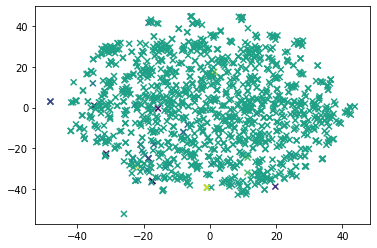

In [8]:
def plot(model, corpus, labels, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_
    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=labels, marker='x')
    plt.show()
labels = np.argmax(model.transform(tfidf_corpus), axis=1)
plot(model, tfidf_corpus, labels)

no clusters generated

# LSA

In [9]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
n_components = 15
X, model_lsa = get_lsa_transformation(n_components, tfidf_corpus)
clusters_lsa = print_and_get_clusters(model_lsa, vectorizer)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Topic 0:
['model', 'algorithm', 'learning', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression']
Topic 1:
['model', 'graph', 'network', 'graphical', 'inference', 'latent', 'causal', 'data', 'variable', 'gaussian']
Topic 2:
['matrix', 'rank', 'estimator', 'low', 'completion', 'estimation', 'covariance', 'sparse', 'tensor', 'norm']
Topic 3:
['kernel', 'regression', 'learning', 'estimator', 'feature', 'density', 'hilbert', 'data', 'rkhs', 'reproducing']
Topic 4:
['matrix', 'rank', 'graph', 'learning', 'clustering', 'low', 'completion', 'label', 'cluster', 'factorization']
Topic 5:
['graph', 'clustering', 'kernel', 'cluster', 'density', 'graphical', 'algorithm', 'node', 'vertex', 'function']
Topic 6:
['policy', 'kernel', 'network', 'graph', 'bound', 'matrix', 'process', 'approximation', 'rank', 'gaussian']
Topic 7:
['bound', 'policy', 'causal', 'sample', 'distribution', 'label', 'regret', 'active', 'minimax', 'class']
Topic 8:
['network', 'neura

similar to other clustering algorithms

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


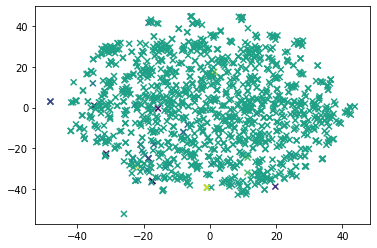

In [11]:
labels_lsa = np.argmax(model.transform(tfidf_corpus), axis=1)
plot(model_lsa, tfidf_corpus, labels)

# Remove words which appear often in all clusters

In [12]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'derivative': 3, 'spurious': 2, 'median': 2, 'interaction': 2, 'policy': 2, 'rule': 2, 'adjustment': 1, 'lda': 1, 'string': 1, 'processor': 1, 'mvc': 1, 'flare': 1, 'minority': 1, 'linkage': 1, 'graspy': 1, 'multilabel': 1, 'gesture': 1, 'bag': 1, 'cascade': 1, 'privacy': 1, 'angle': 1, 'private': 1, 'recognition': 1, 'curriculum': 1, 'multimodal': 1, 'mil': 1, 'hardness': 1, 'stagewise': 1, 'dropout': 1, 'elfi': 1, 'olps': 1, 'patient': 1, 'revenue': 1, 'dnns': 1, 'thundergbm': 1, 'simpledet': 1, 'biclustering': 1, 'mallow': 1, 'svr': 1, 'herded': 1, 'adversary': 1, 'differentiation': 1, 'bibliography': 1, 'alexey': 1, 'aggressive': 1, 'regularisation': 1, 'dkrr': 1, 'diffusion': 1, 'horseshoe': 1, 'divvy': 1, 'grammar': 1, 'vb': 1, 'pomdps': 1, 'conductance': 1, 'lpcc': 1, 'emission': 1, 'jstacs': 1, 'synergy': 1, 'hedge': 1, 'profile': 1, 'lmrl2': 1, 'metropolized': 1, 'modelling': 1, 'nyström': 1, 'preface': 1, 'decoder': 1, 'modal': 1,

In [13]:
terms = list(itertools.chain.from_iterable(clusters_lsa))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'kernel': 7, 'learning': 5, 'matrix': 5, 'graph': 5, 'network': 5, 'causal': 5, 'tensor': 5, 'clustering': 5, 'data': 4, 'regression': 4, 'graphical': 4, 'variable': 4, 'rank': 4, 'estimator': 4, 'bound': 4, 'model': 3, 'algorithm': 3, 'density': 3, 'cluster': 3, 'policy': 3, 'function': 2, 'inference': 2, 'latent': 2, 'gaussian': 2, 'low': 2, 'completion': 2, 'feature': 2, 'label': 2, 'node': 2, 'sample': 2, 'active': 2, 'rate': 2, 'effect': 2, 'selection': 2, 'lasso': 2, 'method': 1, 'problem': 1, 'estimation': 1, 'covariance': 1, 'sparse': 1, 'norm': 1, 'hilbert': 1, 'rkhs': 1, 'reproducing': 1, 'factorization': 1, 'vertex': 1, 'process': 1, 'approximation': 1, 'distribution': 1, 'regret': 1, 'minimax': 1, 'class': 1, 'neural': 1, 'loss': 1, 'deep': 1, 'layer': 1, 'community': 1, 'prediction': 1, 'observational': 1, 'action': 1, 'distributed': 1, 'python': 1, 'library': 1, 'source': 1, 'package': 1, 'stochastic': 1, 'convex': 1, 'non': 1

In [14]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
28it [00:00, 271.84it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 189.03it/s]


In [16]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
model_stopwords = LatentDirichletAllocation(n_components=num_topics)
fit_model(model_stopwords, tfidf_corpus_stopwords)
clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Topic 0:
['sdr', 'environment', 'rsg', 'svr', 'qda', 'smart', 'coordinate', 'budgetedsvm', 'imitation', 'rimle']
Topic 1:
['spurious', 'lpcc', 'derivative', 'experience', 'anomaly', 'stagewise', 'ising', 'pool', 'compression', 'olps']
Topic 2:
['policy', 'ranking', 'topic', 'item', 'line', 'preference', 'message', 'action', 'lda', 'power']
Topic 3:
['completion', 'dictionary', 'entry', 'np', 'hardness', 'instrumental', 'causal', 'hazard', 'cause', 'discovery']
Topic 4:
['kriging', 'teacher', 'surface', 'synergy', 'singularity', 'tensorly', 'submatrix', 'attribute', 'seriation', 'monotonic']
Topic 5:
['multiscale', 'quantum', 'dictionary', 'mdps', 'td', 'reconstruction', 'persistence', 'mvc', 'poisson', 'currently']
Topic 6:
['string', 'privacy', 'query', 'private', 'walk', 'bag', 'dnns', 'ml', 'incomplete', 'utility']
Topic 7:
['worker', 'jstacs', 'multimodal', 'modality', 'java', 'hypothesis', 'mtl', 't3f', 'permanent', 'commute']
Topic 8:
['selector', 'margin',

In [18]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'policy': 3, 'derivative': 2, 'dictionary': 2, 'query': 2, 'hypothesis': 2, 'sdr': 1, 'environment': 1, 'rsg': 1, 'svr': 1, 'qda': 1, 'smart': 1, 'coordinate': 1, 'budgetedsvm': 1, 'imitation': 1, 'rimle': 1, 'spurious': 1, 'lpcc': 1, 'experience': 1, 'anomaly': 1, 'stagewise': 1, 'ising': 1, 'pool': 1, 'compression': 1, 'olps': 1, 'ranking': 1, 'topic': 1, 'item': 1, 'line': 1, 'preference': 1, 'message': 1, 'action': 1, 'lda': 1, 'power': 1, 'completion': 1, 'entry': 1, 'np': 1, 'hardness': 1, 'instrumental': 1, 'causal': 1, 'hazard': 1, 'cause': 1, 'discovery': 1, 'kriging': 1, 'teacher': 1, 'surface': 1, 'synergy': 1, 'singularity': 1, 'tensorly': 1, 'submatrix': 1, 'attribute': 1, 'seriation': 1, 'monotonic': 1, 'multiscale': 1, 'quantum': 1, 'mdps': 1, 'td': 1, 'reconstruction': 1, 'persistence': 1, 'mvc': 1, 'poisson': 1, 'currently': 1, 'string': 1, 'privacy': 1, 'private': 1, 'walk': 1, 'bag': 1, 'dnns': 1, 'ml': 1, 'incomplete': 1

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


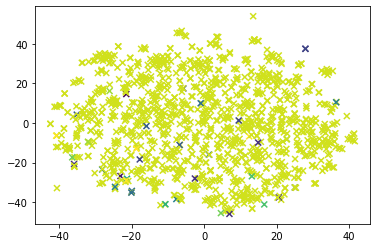

In [19]:
labels_stopwords = np.argmax(model_stopwords.transform(tfidf_corpus_stopwords), axis=1)
plot(model_stopwords, tfidf_corpus_stopwords, labels_stopwords)

In [20]:
n_components = 15
X, model_lsa_stopwords = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
clusters_lsa = print_and_get_clusters(model_lsa_stopwords, vectorizer_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Topic 0:
['problem', 'matrix', 'function', 'kernel', 'regression', 'approach', 'bound', 'based', 'network', 'set']
Topic 1:
['convex', 'rate', 'kernel', 'gradient', 'bound', 'convergence', 'optimization', 'loss', 'stochastic', 'regression']
Topic 2:
['matrix', 'rank', 'low', 'completion', 'clustering', 'graph', 'covariance', 'cluster', 'tensor', 'norm']
Topic 3:
['kernel', 'regression', 'estimator', 'density', 'feature', 'hilbert', 'rkhs', 'mean', 'reproducing', 'space']
Topic 4:
['matrix', 'rank', 'policy', 'low', 'completion', 'library', 'task', 'feature', 'python', 'factorization']
Topic 5:
['graph', 'clustering', 'cluster', 'label', 'network', 'classification', 'machine', 'problem', 'convex', 'kernel']
Topic 6:
['policy', 'kernel', 'graph', 'network', 'approximation', 'gradient', 'matrix', 'clustering', 'stochastic', 'bound']
Topic 7:
['network', 'neural', 'gradient', 'distributed', 'stochastic', 'regression', 'node', 'optimization', 'community', 'structure']

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


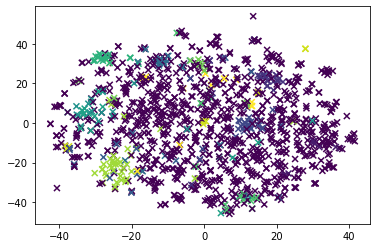

In [21]:
labels_lsa_stopwords = np.argmax(model_lsa_stopwords.transform(tfidf_corpus_stopwords), axis=1)
plot(model_lsa_stopwords, tfidf_corpus_stopwords, labels_lsa_stopwords)

# Metrics

In [22]:
def calc_scores(corpus, model, labels):
    return metrics.silhouette_score(corpus, labels, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), labels), metrics.davies_bouldin_score(corpus.toarray(), labels)
scores = []
score = list(calc_scores(tfidf_corpus, model, labels))
score.insert(0, 'LDA')
scores.append(score)

score = list(calc_scores(tfidf_corpus, model_lsa, labels_lsa))
score.insert(0, 'LSA')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords, labels_stopwords))
score.insert(0, 'LDA_stopwords')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, model_lsa_stopwords, labels_lsa_stopwords))
score.insert(0, 'LSA_stopwords')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      model type  silhouette_score  calinski_harabasz_score  \
0            LDA         -0.005403                 1.102670   
1            LSA         -0.005403                 1.102670   
2  LDA_stopwords         -0.002804                 1.069878   
3  LSA_stopwords         -0.007878                 2.846933   

   davies_bouldin_score  
0              2.690305  
1              2.690305  
2              2.816353  
3              5.055772  


negative scores, maybe because there is one big cluster and the others kind of lie inside of it? so the mean nearest-cluster distance (b) is small and the  mean intra-cluster distance (a) is large. Then b-a will become negative.